In [1]:
import numpy as np
import astropy.units as u

from tardis.energy_input.base import main_gamma_ray_loop

import matplotlib.pyplot as plt
from tardis.model import Radial1DModel
from tardis.io.config_reader import Configuration

config = Configuration.from_yaml("/home/afullard/toy_model_sf_compare/blondin_model_compare_06.yml")

/home/afullard/miniconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
model = Radial1DModel.from_csvy(config)

In [3]:
model.raw_isotope_abundance[10].to_dict()

{(28, 56): 0.2418385489687062}

In [4]:
np.sum(model.density * model.volume).to("M_sun")

<Quantity 0.69229319 solMass>

In [5]:
import tardis.constants as const

energy_ni56 = 2136 * u.keV
energy_co56 = 4566 * u.keV

moles_of_ni56 = model.raw_isotope_abundance.loc[28].values * (model.density * model.volume) / (56 * u.u).to(u.g/u.mol, equivalencies=u.molar_mass_amu())
number_of_ni56 = moles_of_ni56 * const.N_A

# lambda in 1/seconds
lambda_ni56 = np.log(2) / (6.075 * u.day)
lambda_co56 = np.log(2) / (77.3 * u.day)

t_exp = 80 * u.day

number_ni56_after_80_days = number_of_ni56 * np.exp(-lambda_ni56 * t_exp)

decayed_energy_ni56 = number_ni56_after_80_days * lambda_ni56 * energy_ni56

number_co56_after_80_days = (lambda_ni56 / (lambda_co56 - lambda_ni56)) * number_of_ni56 * (np.exp(-lambda_ni56 * t_exp) - np.exp(-lambda_co56 * t_exp))

decayed_energy_co56 = number_co56_after_80_days * lambda_co56 * energy_co56

print("=== Abundances MATCHED ===")
print(number_ni56_after_80_days / number_of_ni56)
print(number_co56_after_80_days / number_of_ni56)

print("=== Masses MATCHED ===")
print(number_ni56_after_80_days / number_of_ni56 * (model.density * model.volume))
print(number_co56_after_80_days / number_of_ni56 * (model.density * model.volume))

print("=== Total activity MATCHED ===")
print((number_ni56_after_80_days * lambda_ni56 + number_co56_after_80_days * lambda_co56).to('1/s'))

total_decayed_energy = decayed_energy_ni56 + decayed_energy_co56
decayed_energy_volume = total_decayed_energy / model.volume

print("=== Abundance normalized activity MATCHED ===")
print(lambda_ni56.to('1/s') * (number_ni56_after_80_days / number_of_ni56))
print(lambda_co56.to('1/s') * (number_co56_after_80_days / number_of_ni56))

print("=== Abundance normalized total activity ===")
print(np.sum(lambda_ni56 * (number_ni56_after_80_days / number_of_ni56) + lambda_co56 * (number_co56_after_80_days / number_of_ni56)).to('1/s'))

print("=== Total decay energy ===")
print(total_decayed_energy.to('erg/s'))
print(decayed_energy_volume.to('erg/s/cm^3'))
print(np.sum(total_decayed_energy).to('keV/s'))


=== Abundances MATCHED ===
[[0.0001086 0.0001086 0.0001086 0.0001086 0.0001086 0.0001086 0.0001086
  0.0001086 0.0001086 0.0001086 0.0001086 0.0001086 0.0001086 0.0001086]]
[[0.52954852 0.52954852 0.52954852 0.52954852 0.52954852 0.52954852
  0.52954852 0.52954852 0.52954852 0.52954852 0.52954852 0.52954852
  0.52954852 0.52954852]]
=== Masses MATCHED ===
[[1.05948345e+27 5.25101938e+27 1.00897638e+28 1.39089580e+28
  1.62332359e+28 1.71431325e+28 1.09474895e+28 7.40186896e+27
  1.59543230e+28 1.45016200e+28 1.28207211e+28 1.10848522e+28
  9.41132327e+27 3.68810553e+27]] g
[[5.16631582e+30 2.56053310e+31 4.92003025e+31 6.78236828e+31
  7.91574640e+31 8.35943555e+31 5.33827952e+31 3.60934308e+31
  7.77974125e+31 7.07136562e+31 6.25171577e+31 5.40526112e+31
  4.58920507e+31 1.79841581e+31]] g
=== Total activity MATCHED ===
[[5.78106532e+45 2.86521569e+46 5.50547378e+46 7.58941487e+46
  8.85765574e+46 9.35414030e+46 5.97349130e+46 3.97194614e+46
  6.91657374e+46 3.98788524e+46 1.69181035e

In [6]:
energy_ni56 = 2136 * u.keV

moles_of_ni56 = 0.595 * u.M_sun / (58.693 * u.g)
number_of_ni56 = moles_of_ni56 * 6.022E23

number_after_80_days = number_of_ni56 * np.exp(-(np.log(2) / 6.075) * 80)

print(number_after_80_days/number_of_ni56)

decayed_energy = number_after_80_days * (1 - np.exp(-(np.log(2) / 524880))) * energy_ni56

print(decayed_energy.to(u.erg)/u.s)

0.0001085972898475382
5.957820434241481e+39 erg / s


In [7]:
(0.97 * (1 - np.exp(-(40/80)**2)) + 0.03) * 0.595 * (6.45 * np.exp(-80/8.8) + 1.45 * np.exp(-80/111.3)) * 10e43 * u.erg /u.s

<Quantity 1.0293457e+43 erg / s>

import pandas as pd
with pd.HDFStore("~/Downloads/tardisnuclear/decay_radiation.h5",) as hdf:
    print(hdf.keys())

pd.read_hdf("~/Downloads/tardisnuclear/decay_radiation.h5", key="/decay_radiation")

In [8]:
# Compute energy deposition rate
# ejecta_energy_df is the deposited energy
# ejecta_plot_energy_df is information for plotting
# escape_energy is the escaping energy
num_decays = int(1e3)

(
    ejecta_energy_df,
    ejecta_plot_energy_df,
    escape_energy,
    scaled_decay_rate
) = main_gamma_ray_loop(
    num_decays,
    model,
)

Data Type Gamma Coincidence Data not known and not parsed
Data Type download-timestamp not known and not parsed
Data Type Gamma Coincidence Data not known and not parsed
Data Type download-timestamp not known and not parsed


Scale factor:  2.9564966
[py.warnings         ][WARNING]  /home/afullard/miniconda3/envs/tardis/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
 (warnings.py:110)
Scale factor:  3.5555065999999993
scaled phot per shell
          Co56  Ni56
0   307.475646   0.0
1   307.475646   0.0
2   307.475646   0.0
3   307.475646   0.0
4   307.475646   0.0
5   307.475646   0.0
6   307.475646   0.0
7   301.562653   0.0
8   245.389218   0.0
9   153.737823   0.0
10   73.912415   0.0
11   23.651973   0.0
12    2.956497   0.0
13    0.000000   0.0
[py.warnings         ][WARNING]  /home/afullard/tardis/tardis/energy_input/base.py:306: RuntimeWarning: divide by zero encountered in true_divide
  decay_rate_per_shell / photons_pe

  0%|          | 0/2946 [00:00<?, ?it/s]

In [9]:
ejecta_energy_df

,energy
0,5.863318e+05
1,6.749566e+05
2,4.209927e+05
3,2.960078e+05
4,2.535149e+05
5,1.168404e+05
6,6.621642e+04
7,6.345886e+04
8,3.478235e+04
9,1.559279e+04


In [10]:
scaled_decay_rate

<Quantity [1.88066431e+43, 9.32096175e+43, 1.79101038e+44, 2.46894661e+44,
           2.88152375e+44, 3.04303736e+44, 1.94326327e+44, 1.31746754e+44,
           2.81935436e+44, 2.59463369e+44, 2.28954095e+44, 1.89775751e+44,
           9.34808570e+43,            inf] 1 / s>

In [11]:
ejecta_energy = ejecta_plot_energy_df["energy_input"]
ejecta_energy_r = ejecta_plot_energy_df["energy_input_r"]
energy_input_time = ejecta_plot_energy_df["energy_input_time"]
energy_input_type = ejecta_plot_energy_df["energy_input_type"]

In [12]:
ejecta_energy_values = [a.value for a in ejecta_energy]
ejecta_energy_r_values = [a.value for a in ejecta_energy_r]

In [13]:
beta = np.where(energy_input_type == -1, ejecta_energy, 0)

In [14]:
len(beta[beta > 0])

215

In [15]:
beta.sum()

<Quantity 131427.2 keV>

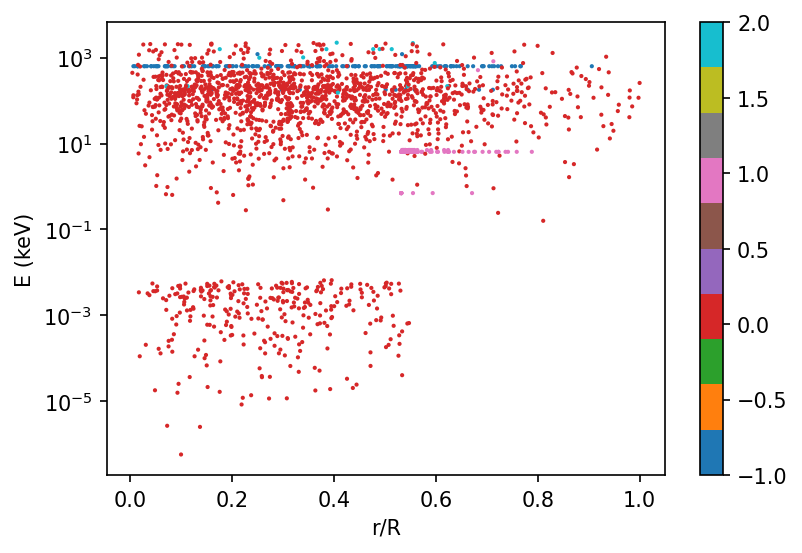

In [16]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)

scatter = ax.scatter(ejecta_energy_r_values/np.max(model.v_outer.value), ejecta_energy_values, c=energy_input_type, s=1, cmap="tab10")
cbar = plt.colorbar(scatter, ax=ax)
ax.set_xlabel("r/R")
ax.set_ylabel("E (keV)")
ax.semilogy();

In [17]:
def read_edep(file):

    """read in edep_*.txt file
    """

    print('INFO - reading file '+file)

    with open(file, 'r') as f:
        
        ### read in header
        okhdr = 0
        while okhdr == 0:
            line = f.readline()
            if 'NTIMES' in line:
                nt = int(line.split()[1])
            elif 'NVEL' in line:
                nvel = int(line.split()[1])
            elif 'TIMES' in line:
                split_line = line.split()
                tarrstr = split_line[1:]
                tarr = [float(tt) for tt in tarrstr]
                okhdr = 1

    ### read numerical data in one go
    vals = np.loadtxt(file)
    velarr = vals[:,0]
    edeparr = np.zeros((nt,nvel))
    for it in range(nt):
        edeparr[it,:] = vals[:,it+1]
                        
    #output
    return np.array(tarr), velarr, edeparr

In [18]:
tarr, vel_arr, edep_arr = read_edep("../toy_model_sf_compare/edep_toy06_sedonaexpansion.txt")

tarr_supernu, vel_arr_supernu, edep_arr_supernu = read_edep("../toy_model_sf_compare/edep_toy06_supernu.txt")

tarr_artis, vel_arr_artis, edep_arr_artis = read_edep("../toy_model_sf_compare/edep_toy06_artis.txt")

tarr_urilight, vel_arr_urilight, edep_arr_urilight = read_edep("../toy_model_sf_compare/edep_toy06_urilight.txt")

INFO - reading file /home/afullard/toy_model_sf_compare/edep_toy06_sedonaexpansion.txt
INFO - reading file /home/afullard/toy_model_sf_compare/edep_toy06_supernu.txt
INFO - reading file /home/afullard/toy_model_sf_compare/edep_toy06_artis.txt
INFO - reading file /home/afullard/toy_model_sf_compare/edep_toy06_urilight.txt


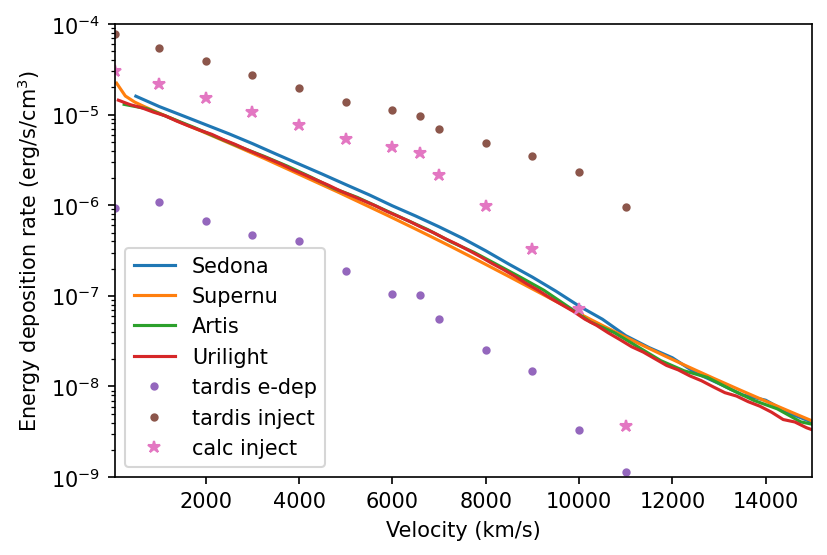

In [19]:
tardis_edep = ejecta_energy_df.to_numpy() * u.eV.to("erg")

tardis_e_inject = [7.76862721e-05, 5.50557139e-05, 3.89466442e-05, 2.75410870e-05,
 1.94805158e-05, 1.38056693e-05, 1.12280794e-05, 9.79436826e-06,
 6.88616807e-06, 4.92888384e-06, 3.47895646e-06, 2.35966968e-06,
 9.68932474e-07, 0]

calc_inject = [3.05356172e-05, 2.16174178e-05, 1.53033191e-05, 1.08330589e-05,
  7.66890748e-06, 5.42883976e-06, 4.41256409e-06, 3.77940648e-06,
  2.16146816e-06, 9.70571320e-07, 3.29706055e-07, 7.15995846e-08,
  3.67569925e-09, 5.28361674e-12]

time_index_sedona = np.where(tarr == 79.609)[0][0]
time_index_supernu = np.where(tarr_supernu == 79.2689863858)[0][0]
time_index_artis = np.where(tarr_artis == 78.87)[0][0]
time_index_urilight = np.where(tarr_urilight == 8.013859e+01)[0][0]
plt.figure(dpi=150)
plt.plot(vel_arr, edep_arr[time_index_sedona, :], label="Sedona")
plt.plot(vel_arr_supernu, edep_arr_supernu[time_index_supernu, :], label="Supernu")
plt.plot(vel_arr_artis, edep_arr_artis[time_index_artis, :], label="Artis")
plt.plot(vel_arr_urilight, edep_arr_urilight[time_index_urilight, :], label="Urilight")
plt.plot(model.v_inner.to("km/s"), tardis_edep, ".", label="tardis e-dep")
plt.plot(model.v_inner.to("km/s"), tardis_e_inject, ".", label="tardis inject")
plt.plot(model.v_inner.to("km/s"), np.array(calc_inject), "*", label="calc inject")
plt.semilogy()
plt.xlim(50, 15000)
plt.legend()
plt.xlabel("Velocity (km/s)")
plt.ylabel("Energy deposition rate (erg/s/cm$^3$)")
plt.ylim(1e-9, 1e-4);

In [20]:
tardis_edep.flatten()

array([9.39407119e-07, 1.08139970e-06, 6.74504728e-07, 4.74256798e-07,
       4.06175713e-07, 1.87198883e-07, 1.06090405e-07, 1.01672303e-07,
       5.57274653e-08, 2.49824013e-08, 1.49333941e-08, 3.34778837e-09,
       1.15066800e-09,            inf])

In [21]:
edep_arr[time_index_sedona, :][:len(tardis_edep)] / tardis_edep.flatten()

array([ 17.0347868 ,  11.37821658,  14.48373835,  16.32651348,
        15.11560096,  25.60709727,  34.74621485,  28.02582321,
        39.54369695,  67.73848425,  87.38937668, 294.49023947,
       660.94477372,   0.        ])

In [22]:
escape_energy_values = [a.value for a in escape_energy]

In [23]:
total = 0
for e, v in zip(tardis_edep, model.volume):
    if e < np.inf:
        total += e * v

In [24]:
total

<Quantity [1.58192659e+41] cm3>